## Implementación de 1 to n NQK

### I) Data re-uploading QNN (de 1 qubit)

Datos de prueba

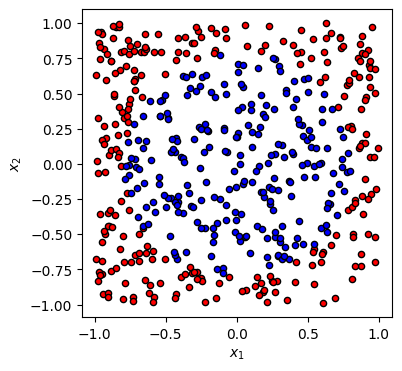

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

import matplotlib.pyplot as plt

#Semilla
np.random.seed(42)

#Datasets de puntos en un circulo
def circle(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Genera datos de puntos en un circulo para clasificación binaria

    Args:
        samples (int): numero de muestras a generar
        center (tuple): centro del circulo
        radius (float: radio del circulo

    Returns:
        Xvals (array[tuple]): coordinadas de puntos
        yvals (array[int]): clasificación de puntos
    """
    Xvals, yvals = [], []

    for i in range(samples):
        x = 2 * (np.random.rand(2)) - 1
        y = 0
        if np.linalg.norm(x - center) < radius:
            y = 1
        Xvals.append(x)
        yvals.append(y)
    return np.array(Xvals, requires_grad=False), np.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    """
    Plotea los datos de puntos en un circulo para clasificación binaria

    Args:
        x (array[tuple]): arreglo de coordenadas de puntos
        y (array[int]): arreglo de etiquetas de clasificación
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

Xdata, ydata = circle(500)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()

# Función para calcular la matriz de densidad
def density_matrix(state):
    """Calcula la matriz de densidad a partir de un vector de estado  

    Args:
        state (array[complex]): arreglo que representa el vector de estado
    Returns:
        dm: (array[complex]): arreglo que representa la matriz de densidad
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = np.array([label_0, label_1], requires_grad=False)

Circuito del QNN con data reloading y fidelity

In [ ]:
dev = qml.device("lightning.qubit", wires=1)


@qml.qnode(dev)
def qcircuit(params, x, y):
    """Circuito variacional con data reloading.

    Args:
        params (array[float]): arreglo de parámetros
        x (array[float]): input
        y (array[float]): etiquetas

    Returns:
        float: fidelity entre la salida del circuito y la etiqueta
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Función de costo

    Args:
        params (array[float]): arreglo de parámetros
        x (array[float]): 2-d arreglo de inputs
        y (array[float]): 1-d arreglo de etiquetas
        state_labels (array[float]): arreglo de etiquetas como vectores de estado

    Returns:
        float: costo promedio sobre el batch
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

Testeo y batches

In [3]:
def test(params, x, y, state_labels=None):
    """
    Testeo

    Args:
        params (array[float]): arreglo de parametros
        x (array[float]): 2-d arreglo de input vectors
        y (array[float]): 1-d arreglo de targets
        state_labels (array[float]): 1-d arreglo de representaciones de estado para las etiquetas
    Returns:
        predicted (array([int]): labels predichas para los datos de test
        output_states (array[float]): estados cuanticos de salida del circuito
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Precisión

    Args:
        y_true (array[float]): 1-d arreglo de targets
        y_predicted (array[float]): 1-d arreglo de predicciones
        state_labels (array[float]): 1-d arreglo de representaciones de estado para las etiquetas

    Returns:
        score (float): fraccion de muestras clasificadas correctamente
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    generador de batches

    Args:
        inputs (array[float]): data de entrada
        targets (array[float]): targets

    Returns:
        inputs (array[float]): un batch de inputs de longitud `batch_size`
        targets (array[float]): un batch de targets de longitud `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

Entrenamiento del circuito clasificador

In [3]:
# Generar datos de entrenamiento y testeo
num_training = 10
num_test = 50

Xdata, y_train = circle(num_training)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1), requires_grad=False)))

Xtest, y_test = circle(num_test)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1), requires_grad=False)))



In [4]:
# Entrenamiento del circuito clasificador
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# Inicializa parametros aleatorios
params = np.random.uniform(size=(num_layers, 3), requires_grad=True)



In [7]:
def qcircuit(params, x, y):
    """Circuito variacional con data reloading.

    Args:
        params (array[float]): arreglo de parámetros
        x (array[float]): input
        y (array[float]): etiquetas

    Returns:
        float: fidelity entre la salida del circuito y la etiqueta
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)



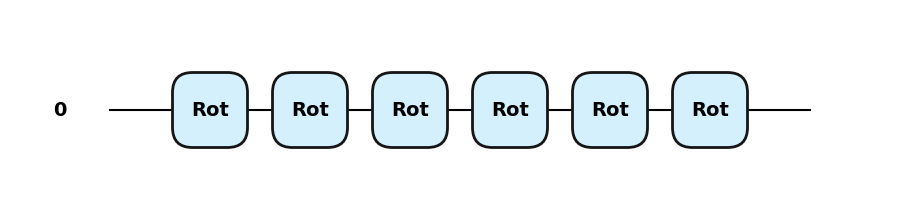

In [8]:
qml.draw_mpl(qcircuit, style= 'pennylane' )(params, X_train[0],y_train[0])
plt.show()

In [ ]:
predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# guardamos las predicciones con pesos aleatorios para comparación
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

In [16]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
learned_params = params
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

Cost: 0.133129 | Train accuracy 0.800000 | Test Accuracy : 0.640000
Learned weights
Layer 0: [0.04437666 0.85219353 0.03542237]
Layer 1: [0.32905137 0.93158949 0.73521265]
Layer 2: [0.28139096 0.25264909 0.00508214]


### II) 1-n EQK 

Embedding con parámetros aprendidos del QNN

In [7]:
def circuito_embedding(params, x, n):
    for p in params:
        #Rotaciones
        for i in range(n):
            qml.Rot(*x, wires=i)
            qml.Rot(*p, wires=i)
        
        #cascada de E (cnots)
        for i in range(n-1): qml.CNOT(wires=[i,i+1]) 



#adjunto

adjunto_empedding=qml.adjoint(circuito_embedding)

Creación circuito kernel con n=3

In [8]:
n=3
dev3 = qml.device("default.qubit", wires=n)
wires = dev3.wires.tolist()

@qml.qnode(dev3)
def circuito_kernel(x1,x2, params,n):
    circuito_embedding(params, x1, n)
    adjunto_empedding(params, x2, n)
    return qml.probs(wires=wires)

Valor de kernel

In [9]:
def kernel(x1, x2, params,n):
    return circuito_kernel(x1, x2, params,n)[0]

In [ ]:
#Probando kernel entre 2 puntos
kernel(X_train[0], X_train[1], learned_params, n)

tensor(0.28156454, requires_grad=True)

Construyendo matriz kernel

In [12]:
init_kernel = lambda x1, x2: kernel(x1, x2,learned_params, n)
#K_matrix = qml.kernels.square_kernel_matrix(X_train, init_kernel,assume_normalized_kernel=True)
#K_matrix.size

#### Usando matriz NQK kernel en SVC

In [2]:
from sklearn.svm import SVC
svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)).fit(X_train,y_train) 

NameError: name 'X_train' is not defined

Accuracy medida

In [ ]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)

nqk_accuracy = accuracy(svm, X_test, y_test)

Comparación de performances

In [ ]:
print("Test accuracy de QNN: ", accuracy_test)
print(f"Test accuracy de 1 to {n} NQK : {nqk_accuracy}")

Test accuracy de QNN:  0.64
Test accuracy de 1 to 3 NQK : 0.76


Se espera normalmente que el NQK tenga mayor o igual precision que el QNN. La precision está baja porque se usaron muy pocos datos de entrenamiento (deberian ser del orden de 1000) porque construir la matriz Kernel crece con O(n^2) y demora mucho en mi laptop para valores altos, quiza deberia probar en alguna pc de la facu.